<picture>
  <source media="(prefers-color-scheme: dark)" srcset="https://vespa.ai/assets/vespa-ai-logo-heather.svg">
  <source media="(prefers-color-scheme: light)" srcset="https://vespa.ai/assets/vespa-ai-logo-rock.svg">
  <img alt="#Vespa" width="200" src="https://vespa.ai/assets/vespa-ai-logo-rock.svg" style="margin-bottom: 25px;">
</picture>

# Feeding performance

This explorative notebook intends to shine some light on the different modes of feeding documents to Vespa.
We will look at these 3 different methods:

1. Using `feed_iterable()`.
2. Using `feed_iterable_async()`
3. Using [Vespa CLI](https://docs.vespa.ai/en/vespa-cli)


<div class="alert alert-info">
    Refer to <a href="https://pyvespa.readthedocs.io/en/latest/troubleshooting.html">troubleshooting</a>
    for any problem when running this guide.
</div>


[Install pyvespa](https://pyvespa.readthedocs.io/), Vespa CLI, and start Docker Daemon.

> The `vespacli` python package is just a thin wrapper, allowing for installation through pypi.
> Do NOT install if you already have the Vespa CLI installed.


In [1]:
!pip3 install pyvespa vespacli
!docker info

Defaulting to user installation because normal site-packages is not writeable
     |████████████████████████████████| 49.3 MB 3.0 MB/s eta 0:00:01
  Consider adding this directory to PATH or, if you prefer to suppress this warning, use --no-warn-script-location.
You should consider upgrading via the '/Library/Developer/CommandLineTools/usr/bin/python3 -m pip install --upgrade pip' command.
Emulate Docker CLI using podman. Create /etc/containers/nodocker to quiet msg.
host:
  arch: arm64
  buildahVersion: 1.35.3
  cgroupControllers:
  - cpu
  - io
  - memory
  - pids
  cgroupManager: systemd
  cgroupVersion: v2
  conmon:
    package: conmon-2.1.10-1.fc39.aarch64
    path: /usr/bin/conmon
    version: 'conmon version 2.1.10, commit: '
  cpuUtilization:
    idlePercent: 95.57
    systemPercent: 1.48
    userPercent: 2.95
  cpus: 6
  databaseBackend: sqlite
  distribution:
    distribution: fedora
    variant: coreos
    version: "39"
  eventLogger: journald
  freeLocks: 2044
  hostname: l

## Create an application package

The [application package](https://pyvespa.readthedocs.io/en/latest/reference-api.html#vespa.package.ApplicationPackage)
has all the Vespa configuration files -
create one from scratch:


In [2]:
from vespa.package import (
    ApplicationPackage,
    Field,
    Schema,
    Document,
    FieldSet,
)

package = ApplicationPackage(
    name="pyvespafeed",
    schema=[
        Schema(
            name="doc",
            document=Document(
                fields=[
                    Field(name="id", type="string", indexing=["summary"]),
                    Field(name="text", type="string", indexing=["summary"]),
                ]
            ),
            fieldsets=[FieldSet(name="default", fields=["text"])],
        )
    ],
)

Note that the `ApplicationPackage` name cannot have `-` or `_`.


## Deploy the Vespa application

Deploy `package` on the local machine using Docker,
without leaving the notebook, by creating an instance of
[VespaDocker](https://pyvespa.readthedocs.io/en/latest/reference-api.html#vespa.deployment.VespaDocker). `VespaDocker` connects
to the local Docker daemon socket and starts the [Vespa docker image](https://hub.docker.com/r/vespaengine/vespa/).

If this step fails, please check
that the Docker daemon is running, and that the Docker daemon socket can be used by clients (Configurable under advanced settings in Docker Desktop).


In [3]:
from vespa.deployment import VespaDocker

vespa_docker = VespaDocker()
app = vespa_docker.deploy(application_package=package)

/Users/thomas/Repos/pyvespa/pyvespa/lib/python3.9/site-packages/urllib3/__init__.py:35: NotOpenSSLWarning: urllib3 v2 only supports OpenSSL 1.1.1+, currently the 'ssl' module is compiled with 'LibreSSL 2.8.3'. See: https://github.com/urllib3/urllib3/issues/3020
  warnings.warn(


Waiting for configuration server, 0/300 seconds...
Using plain http against endpoint http://localhost:8080/ApplicationStatus
Waiting for application status, 0/300 seconds...
Using plain http against endpoint http://localhost:8080/ApplicationStatus
Waiting for application status, 5/300 seconds...
Using plain http against endpoint http://localhost:8080/ApplicationStatus
Waiting for application status, 10/300 seconds...
Using plain http against endpoint http://localhost:8080/ApplicationStatus
Application is up!
Finished deployment.


`app` now holds a reference to a [Vespa](https://pyvespa.readthedocs.io/en/latest/reference-api.html#vespa.application.Vespa) instance.


## Preparing the data

In this example we use [HF Datasets](https://huggingface.co/docs/datasets/index) library to stream the
["Cohere/wikipedia-2023-11-embed-multilingual-v3"](https://huggingface.co/datasets/Cohere/wikipedia-2023-11-embed-multilingual-v3) dataset and index in our newly deployed Vespa instance.

The dataset contains wikipedia-pages, and their corresponding embeddings.

> For this exploration we will just use the `id` and `text`-fields

The following uses the [stream](https://huggingface.co/docs/datasets/stream) option of datasets to stream the data without
downloading all the contents locally.

The `map` functionality allows us to convert the
dataset fields into the expected feed format for `pyvespa` which expects a dict with the keys `id` and `fields`:

`{ "id": "vespa-document-id", "fields": {"vespa_field": "vespa-field-value"}}`


In [4]:
from datasets import load_dataset

dataset = load_dataset(
    "Cohere/wikipedia-2023-11-embed-multilingual-v3",
    "ext",
    split="train",
    streaming=False,
)
vespa_feed = dataset.map(
    lambda x: {"id": x["_id"] + "-iter", "fields": {"text": x["text"]}}
)

In [5]:
vespa_feed_iter = vespa_feed.select_columns(["id", "fields"])

In [6]:
from vespa.application import Vespa

app = Vespa(url="http://localhost", port="8080")

## Feeding sync


In [7]:
import time

start = time.time()
responses = app.feed_iterable(
    vespa_feed_iter,
    schema="doc",
    namespace="pyvespa-feed",
    operation_type="update",
    create=True,
)
end = time.time()
sync_feed_time = end - start
print(f"Feed time sync: {sync_feed_time}")

Preparing update requests...


10967 Requests [00:13, 787.11 Requests/s]

Requests completed
Feed time sync: 13.93797492980957


# Feeding async

With the next release of `pyvespa`, we will have the `feed_iterable_async` method available, which should make the feeding process a lot faster.

> One thing to keep in mind is that this function will only have one thread available, and will context switch between all the tasks.
> This means that when feeding many requests, it will take some time before any of the tasks are finished, which might make the user wonder if something is wrong.


In [8]:
start = time.time()
responses = await app.feed_iterable_async(
    vespa_feed_iter, schema="doc", namespace="pyvespa-feed"
)
end = time.time()
async_feed_time = end - start
print(f"Feed time async: {async_feed_time}")

Preparing feed requests...


100%|██████████| 10967/10967 [00:04<00:00, 2647.01 Requests/s]

Requests completed
Feed time async: 4.34295916557312


Nice! 🤩
We got a ~3x speedup by using the async method.

Even more can be expected in scenarios where requests will travel over the network, e.g. when feeding to [Vespa Cloud](https://cloud.vespa.ai/).

We have not looked at multiprocessing, but for very large datasets, one approach could be to read the data in non-overlapping splits, and feed each split in different python processes. Maybe we will explore this in a future notebook.


## Feeding with Vespa CLI

[Vespa CLI](https://docs.vespa.ai/en/vespa-cli) is a command-line interface for interacting with Vespa.
Among many useful features are a `vespa feed` command that is the recommended way of feeding large datasets into Vespa.


## Prepare the data for Vespa CLI

Vespa CLI can feed data from either many .json files or a single .jsonl file with many documents.
The json format needs to be in the following format:

```json
{
  "put": "id:namespace:document-type::document-id",
  "fields": {
    "field1": "value1",
    "field2": "value2"
  }
}
```

Where, `put` is the document operation in this case. Other allowed operations are `get`, `update` and `remove`.

For reference, see https://docs.vespa.ai/en/vespa-cli#cheat-sheet


In [9]:
vespa_json_feed = vespa_feed.map(
    lambda x: {
        "put": f"id:pyvespa-feed:doc::{x['_id']}-json",
        "fields": {"text": x["text"]},
    }
)

In [10]:
vespa_json_feed.select_columns(["put", "fields"]).to_json(
    "vespa_feed.json", orient="records", lines=True
)

Creating json from Arrow format:   0%|          | 0/11 [00:00<?, ?ba/s]

4505289

In [11]:
from pprint import pprint
import json

with open("vespa_feed.json", "r") as f:
    sample = f.readline()
    pprint(json.loads(sample))

{'fields': {'text': 'Güiquipedia Ayúa Zona prevas Índizi A–Z El conceju La '
                    'troji Embassy Help for non-Extremaduran speakers Ayuda '
                    "para quienes no hablan estremeñu'''"},
 'put': 'id:pyvespa-feed:doc::20231101.ext_246_0-json'}


In [12]:
output_list = !vespa feed vespa_feed.json
results = json.loads("".join(output_list))
results

{'feeder.operation.count': 10967,
 'feeder.seconds': 1.023,
 'feeder.ok.count': 10967,
 'feeder.ok.rate': 10725.075,
 'feeder.error.count': 0,
 'feeder.inflight.count': 0,
 'http.request.count': 10967,
 'http.request.bytes': 3295053,
 'http.request.MBps': 3.222,
 'http.exception.count': 0,
 'http.response.count': 10967,
 'http.response.bytes': 1380468,
 'http.response.MBps': 1.35,
 'http.response.error.count': 0,
 'http.response.latency.millis.min': 47,
 'http.response.latency.millis.avg': 95,
 'http.response.latency.millis.max': 270,
 'http.response.code.counts': {'200': 10967}}

In [13]:
print(f"CLI Feed time: {results['feeder.seconds']}")

CLI Feed time: 1.023


Told you the CLI was fast! 🚀
As you can see, the CLI is by far the fastest way to feed data into Vespa.


## Conclusion


In [14]:
!pip3 install matplotlib

zsh:1: command not found: pip


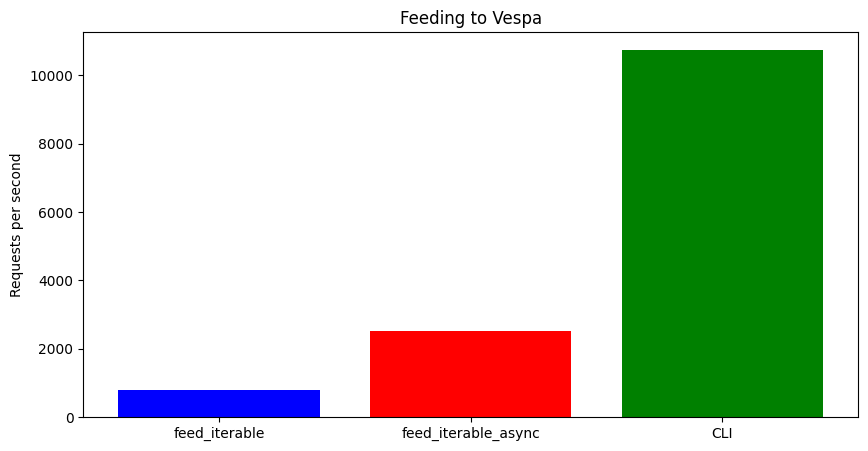

In [19]:
# A beautiful visualization (Tufte style) of requests per second for sync, async and CLI
import matplotlib.pyplot as plt

num_requests = len(vespa_feed)
plt.figure(figsize=(10, 5))
plt.bar(
    ["feed_iterable", "feed_iterable_async", "CLI"],
    [
        num_requests / sync_feed_time,
        num_requests / async_feed_time,
        num_requests / results["feeder.seconds"],
    ],
    color=["blue", "red", "green"],
)
plt.ylabel("Requests per second")
plt.title("Feeding to Vespa")
plt.show()

- Prefer to use the CLI if you care about performance. 🚀
- If you are using Python, prefer the async method, as it is the fastest way to feed data using `pyvespa`.
- If you _really_ don`t like async, the sync method will also work, if you are not in a hurry. ☕


## Cleanup


In [16]:
vespa_docker.container.stop()
vespa_docker.container.remove()

## Next steps

This is just an intro into the capabilities of Vespa and pyvespa.
Browse the site to learn more about schemas, feeding and queries -
find more complex applications in
[examples](https://pyvespa.readthedocs.io/en/latest/examples.html).
